In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap

In [441]:
data = pd.read_csv('geyser.csv')
from sklearn.utils import shuffle
data = shuffle(data)
print(data.head())

      x    y class
12    1  3.4     N
117  16  4.4     N
172  20  4.2     N
93    7  2.0     P
70    6  4.0     P


In [442]:
data.shape

(222, 3)

In [443]:
data['class'] = data['class'].map({'P': 1, 'N': -1})


In [444]:
import random
class svm:
    def __init__(self, i_max=100, kernel="linear", C=1.0, epsilon=10E-5, sigma=0.1, dim=2):
        self.sigma = sigma
        self.dim=dim
        if kernel == "linear":
            self.kernel = lambda a, b: np.dot(a, b.T)
            #print (type(self.kernel))
        elif kernel == "poly":
            self.kernel = lambda a, b: (np.dot(a, b.T))**self.dim
        elif kernel == "rbf":
            #self.kernel = lambda a, b: np.exp(sum(-np.abs(a - b)**2)/((2*sigma)**2))
            self.kernel = lambda x, y: np.exp(-np.sqrt(np.linalg.norm(x-y) ** 2 / (2 * self.sigma ** 2)))
            #print (type(self.kernel))
        else:
            raise ValueError(kernel + " kernel not found")
        self.i_max = i_max
        self.C = C
        self.epsilon = epsilon
        

    def fit(self, X, Y):
        self.m = X.shape[0]
        self.X = X
        self.Y = Y
        self.alpha = np.zeros((self.m))
        self.b = 0.0
        it = 0
        while it < self.i_max:
            #print ("Iteration %d" % it)
            n_changed = 0
            for i in range(0,self.m-1):
                
                E_i = self.__f(X[i,:]) - Y[i]
                if (Y[i] * E_i < -self.epsilon and self.alpha[i] < self.C) or (Y[i] * E_i > self.epsilon and self.alpha[i] > 0):
                    j = i
                    while j == i:
                        j = random.randint(0,self.m-1)
                    E_j = self.__f(X[j,:]) - Y[j]
                    a_i_old = self.alpha[i]
                    a_j_old = self.alpha[j]
                    if Y[i] != Y[j]:
                        L = max(0.0, self.alpha[j] - self.alpha[i])
                        H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
                    else:
                        L = max(0.0, self.alpha[i] + self.alpha[j] - self.C)
                        H = min(self.C, self.alpha[i] + self.alpha[j])
                    if L == H:
                        continue
                    k_ii = self.kernel(X[i,:], X[i,:])
                    k_ij = self.kernel(X[i,:], X[j,:])
                    k_jj = self.kernel(X[j,:], X[j,:])
                    eta = 2 *  k_ij - k_ii - k_jj
                    if eta >= 0:
                        continue
                    self.alpha[j] -= Y[j] * (E_i - E_j) / eta
                    if self.alpha[j] > H:
                        self.alpha[j] = H
                    elif self.alpha[j] < L:
                        self.alpha[j] = L
                    if abs(self.alpha[j] - a_j_old) < 10E-5:
                        continue
                    self.alpha[i] += Y[i] * Y[j] * (a_j_old - self.alpha[j])
                    b_1 = self.b - E_i - Y[i] * (self.alpha[i] - a_i_old) * k_ii - Y[j] * (self.alpha[j] - a_j_old) * k_ij
                    b_2 = self.b - E_j - Y[i] * (self.alpha[i] - a_i_old) * k_ij - Y[i] * (self.alpha[j] - a_j_old) * k_jj
                    if 0 < self.alpha[i] and self.alpha[i] < self.C:
                        self.b = b_1
                    elif 0 < self.alpha[j] and self.alpha[j] < self.C:
                        self.b = b_2
                    else:
                        self.b = (b_1 + b_2)/2
                    n_changed += 1
            if n_changed == 0:
                it += 1
            else:
                it = 0
        alpha_idx = np.where(self.alpha > 0)[0]
        #support_vectors = X[alpha_idx, :]    
        return alpha_idx

    def __f(self, X):
        f = [self.alpha[i] * self.Y[i] * self.kernel(self.X[i,:], X) for i in range(0,self.m-1)]
        f = np.sum(f) + self.b
        return f

    def predict(self, X):
        if type(X) is not np.ndarray:
            #print (type(X))
            X = np.array(X)
        f = np.array([self.__f(X[i,:]) for i in range(X.shape[0])])
        return np.sign(f)
    
    


In [445]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
def cross_val(x, y, darray):
    n, m = x.shape
    for i in range (5):
        n_train = (int)(0.8*n)
        n_test = (int)(0.2*n)
        X_train1 = x.iloc[:(n_test*i), :]
        y_train1 = y.iloc[:(n_test*i)]
        X_train1 = np.array(X_train1)
        y_train1 = np.array(y_train1)

        X_test = x.iloc[(n_test*i):(n_test*(i+1)), :]
        y_test = y.iloc[(n_test*i):(n_test*(i+1))]
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        
        X_train2 = x.iloc[(n_test*(i+1)):, :]
        y_train2 = y.iloc[(n_test*(i+1)):]
        X_train2 = np.array(X_train2)
        y_train2 = np.array(y_train2)
        
        #print(X_train1)
        #print(X_train2)
        
        X_train = np.concatenate((X_train1, X_train2))
        y_train = np.concatenate((y_train1, y_train2))
        
        for d in range (1, 11):
            model = svm(i_max=10, kernel='poly', dim=d)
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            darray[d] += f1_score(y_test, pred)
            print("d=" + str(d) + ": " + str(f1_score(y_test, pred)))
        #darray /= 10
        #return darray
    darray /= 5
    return darray

In [439]:
from sklearn import preprocessing
import pandas as pd
#x = np.array(data.iloc[:,0:2])
#y = np.array(data.iloc[:,2])
x = data.drop('class', 1)
y = data['class']
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x = pd.DataFrame(x_scaled)
#X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)
#X_train = np.array(X_train)
#y_train = np.array(y_train.astype(np.float64))

arr = np.zeros(11)
print (cross_val(x, y, arr))
#print (darray)

n, m = x.shape
n_train = (int)(0.8*n)
n_test = (int)(0.2*n)
X_train = x.iloc[:n_train, :]
y_train = y.iloc[:n_train]
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = x.iloc[n_train:, :]
y_test = y.iloc[n_train:]
X_test = np.array(X_test)
y_test = np.array(y_test)

#for i in range(5):
    

#X_train = np.array(data.iloc[:180,0:2])
#y_train = np.array(data.iloc[:180,2]).astype(np.float64)
#X_test = np.array(X_test)
#y_test = np.array(y_test)

#print (model.predict([[1.5,1.7]]))

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


d=1: 0.0
d=2: 0.4999999999999999
d=3: 0.6206896551724138
d=4: 0.6666666666666667
d=5: 0.7499999999999999
d=6: 0.7499999999999999
d=7: 0.7499999999999999
d=8: 0.7499999999999999
d=9: 0.7499999999999999
d=10: 0.787878787878788
d=1: 0.36363636363636365
d=2: 0.36363636363636365
d=3: 0.56
d=4: 0.6666666666666666
d=5: 0.6666666666666666
d=6: 0.6428571428571428
d=7: 0.6428571428571428
d=8: 0.6206896551724137
d=9: 0.6206896551724137
d=10: 0.6206896551724137
d=1: 0.5625
d=2: 0.6428571428571429
d=3: 0.6666666666666667
d=4: 0.6666666666666667
d=5: 0.72
d=6: 0.72
d=7: 0.72
d=8: 0.72
d=9: 0.6923076923076924
d=10: 0.6923076923076924
d=1: 0.0
d=2: 0.6896551724137931
d=3: 0.7407407407407407
d=4: 0.6153846153846154
d=5: 0.6153846153846154
d=6: 0.6153846153846154
d=7: 0.6666666666666667
d=8: 0.6428571428571429
d=9: 0.6428571428571429
d=10: 0.6428571428571429
d=1: 0.0
d=2: 0.0
d=3: 0.0
d=4: 0.7200000000000001
d=5: 0.8666666666666666
d=6: 0.8125000000000001
d=7: 0.8125000000000001
d=8: 0.8125000000000001


In [446]:
from sklearn import preprocessing
import pandas as pd
#x = np.array(data.iloc[:,0:2])
#y = np.array(data.iloc[:,2])
x = data.drop('class', 1)
y = data['class']
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x = pd.DataFrame(x_scaled)
#X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)
#X_train = np.array(X_train)
#y_train = np.array(y_train.astype(np.float64))

arr = np.zeros(11)
print (cross_val(x, y, arr))
#print (darray)

n, m = x.shape
n_train = (int)(0.8*n)
n_test = (int)(0.2*n)
X_train = x.iloc[:n_train, :]
y_train = y.iloc[:n_train]
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = x.iloc[n_train:, :]
y_test = y.iloc[n_train:]
X_test = np.array(X_test)
y_test = np.array(y_test)

#for i in range(5):
    

#X_train = np.array(data.iloc[:180,0:2])
#y_train = np.array(data.iloc[:180,2]).astype(np.float64)
#X_test = np.array(X_test)
#y_test = np.array(y_test)

#print (model.predict([[1.5,1.7]]))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


d=1: 0.7999999999999999
d=2: 0.6956521739130435
d=3: 0.7200000000000001
d=4: 0.6206896551724137
d=5: 0.6249999999999999
d=6: 0.5714285714285715
d=7: 0.5714285714285715
d=8: 0.5714285714285715
d=9: 0.5555555555555556
d=10: 0.5714285714285715
d=1: 0.888888888888889
d=2: 0.9473684210526316
d=3: 0.8571428571428572
d=4: 0.8372093023255814
d=5: 0.8372093023255814
d=6: 0.8372093023255814
d=7: 0.9
d=8: 0.7096774193548387
d=9: 0.4
d=10: 0.2608695652173913
d=1: 0.9268292682926829
d=2: 0.9268292682926829
d=3: 0.9090909090909091
d=4: 0.8695652173913043
d=5: 0.8695652173913043
d=6: 0.8837209302325582
d=7: 0.5806451612903226
d=8: 0.5806451612903226
d=9: 0.42857142857142855
d=10: 0.42857142857142855
d=1: 0.8
d=2: 0.8387096774193548
d=3: 0.823529411764706
d=4: 0.823529411764706
d=5: 0.7999999999999999
d=6: 0.7999999999999999
d=7: 0.8387096774193548
d=8: 0.5
d=9: 0.3636363636363636
d=10: 0.2857142857142857
d=1: 0.7142857142857143
d=2: 0.8000000000000002
d=3: 0.7741935483870968
d=4: 0.7500000000000001
d

In [447]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score

kernels = ['linear', 'poly', 'rbf']
for k in kernels:
    s = 2
    #while s <= 10:
    model = svm(i_max=10, kernel=k, dim=s)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print("My SVM - " + k + " dimension=" + str(s))
    #print(r2_score(y_test, pred))
    #print(mean_squared_error(y_test, pred))
    print(f1_score(y_test, pred))
    yy = 0
    n = 0
    for i, j in zip(y_test, pred):
        if i == j:
            yy += 1
        else:
            n += 1
    print (yy, n)
    print("Sklearn SVM: " + k)
    clf = SVC(kernel=k)
    print(clf.fit(X_train, y_train))
    prediction = clf.predict(X_test)
    #print(clf.score(X_test, y_test))
    #print(mean_squared_error(y_test, prediction))
    #print(r2_score(y_test, prediction))
    print(f1_score(y_test, prediction))
    yy = 0
    n = 0
    for i, j in zip(y_test, prediction):
        if i == j:
            yy += 1
        else:
            n += 1
    print (yy, n)
    #if k != 'poly':
    #    s += 10
    #s += 1

My SVM - linear dimension=2
0.7142857142857143
37 8
Sklearn SVM: linear
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
0.7142857142857143
37 8
My SVM - poly dimension=2
0.8000000000000002
39 6
Sklearn SVM: poly
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
0.8000000000000002
39 6


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


My SVM - rbf dimension=2
0.6666666666666667
36 9
Sklearn SVM: rbf
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
0.7142857142857143
37 8


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [448]:
def plot_decision(x, y, classifier, title, idx=[], resolution=0.02):
    plt.rcParams['figure.figsize'] = [10, 7]
    colors = ('blue', 'green')
    cmap = ListedColormap(colors[:len(np.unique(y))])        
    
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    classes = classifier.predict(np.c_[xx1.ravel(), xx2.ravel()])
    classes = classes.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, classes, alpha=0.4, cmap=cmap)
    
    for elem_x, elem_y in zip(x, y):
        if elem_y == 0:
            plt.scatter(elem_x[0], elem_x[1], s=40, color=colors[0])
        else:
            plt.scatter(elem_x[0], elem_x[1], s = 40, color=colors[1])
    if idx != []:        
        plt.scatter(x[:, 0][idx], x[:, 1][idx], c=y[idx], cmap=cmap, s=40, edgecolors='black')
    else:
        plt.scatter(x[:, 0][classifier.support_], x[:, 1][classifier.support_], c=y[classifier.support_], cmap=cmap, s=40, edgecolors='black')
    plt.title(title)
    
    plt.show()

0.5454545454545454


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


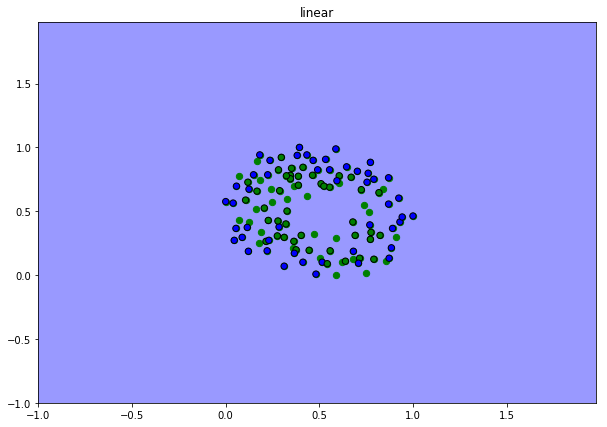

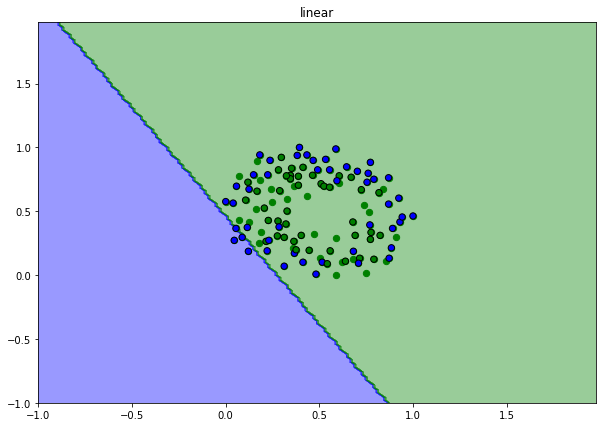

0.7499999999999999


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


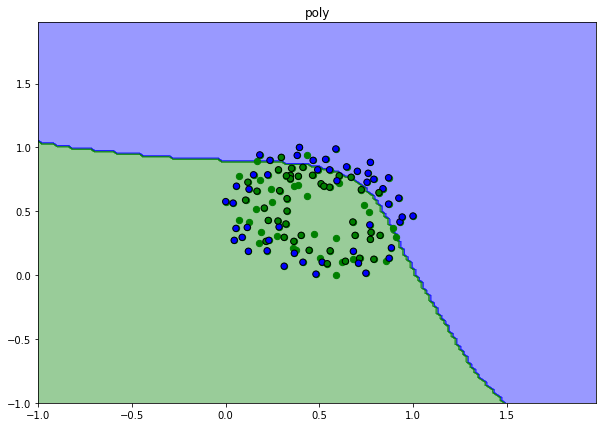

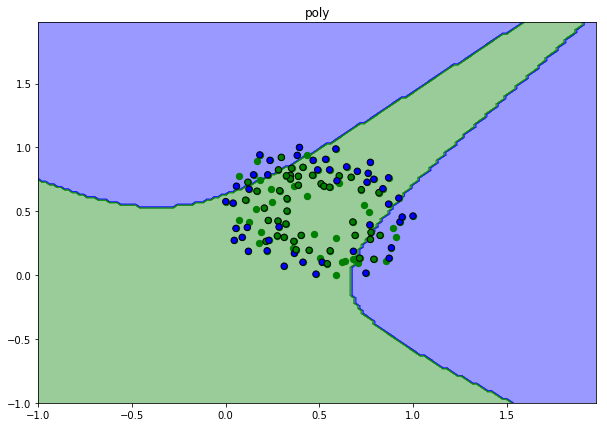

0.75


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


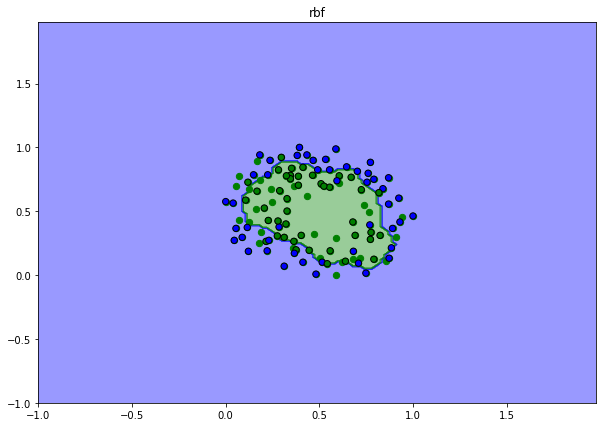

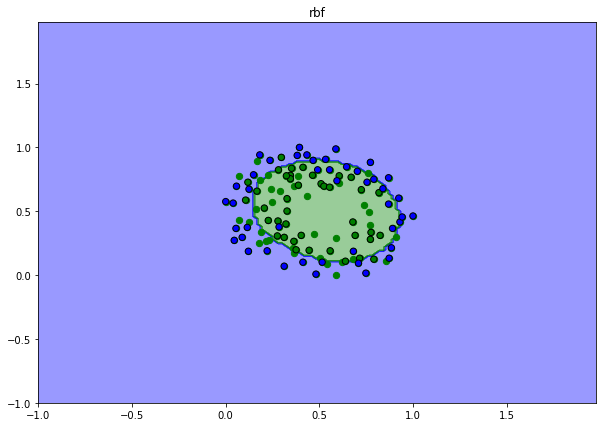

In [451]:
data = pd.read_csv('chips.csv')
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
data = shuffle(data)
data['class'] = data['class'].map({'P': 1, 'N': -1})

x = data.drop('class', 1)
y = data['class']
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x = pd.DataFrame(x_scaled)
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)

X_train = np.array(X_train)
y_train = np.array(y_train.astype(np.float64))

kernels=['linear', 'poly', 'rbf']
for k in kernels:
    classifier = SVC(kernel=k, gamma='scale').fit(X_train, y_train)
    model = svm(i_max=10, kernel=k, dim=5)
    idx = model.fit(X_train, y_train)

    #scores = cross_val_score(classifier, x, y, cv=5)
    #print(scores)

    pred = model.predict(X_test)
    #print("My SVM - " + k + " sigma=" + str(s))
    print(f1_score(y_test, pred))
    plot_decision(x.values, y.values, model, k, idx)
    plot_decision(x.values, y.values, classifier, k)